# Desenvolvimento do trabalho na semana 


### Diagrama
![title](diagram.png)

In [1]:
import pandas as pd
import seaborn as sns
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from tabulate import tabulate

color_names = []
for j in mcolors.CSS4_COLORS:
    color_names.append(j)

## Carregando os dados

In [2]:
import json

with open('../data/rebin_test.json', 'r') as JSON:
    json_dict = json.load(JSON)
data = json.loads(json_dict)    

In [3]:
## Keys do dicionario
data.keys()

#Image index : id da imagem
#Filter_name : Nome do filtro aplicado
#count : Numero de pixels da imagem
#Filter_parameter: valor do parâmetro
#time : tempo de execucao da filtragem
#ROC: Rocs extraidas

dict_keys(['Image_index', 'Filter_name', 'count', 'Filter_parameter', 'time', 'ROC'])

In [4]:
n_images = len(data['Image_index'])
print(n_images)

51


In [5]:
data['ROC'].keys()
#full: roc da imagem 2048 x 2048
#rb_mean: roc da imagem com rebinagem utilizando média
#rb_median: roc da imagem com rebinagem utilizando mediana
#threshold: vetor de thresholds

dict_keys(['full', 'rb_mean', 'rb_median', 'threshold'])

In [6]:
roc_full_image = np.array(data['ROC']['full']) # n_images x (sg_eff, bg_eff) x n_points x n_filters
roc_rebin_mean = np.array(data['ROC']['rb_mean']) # n_images x (sg_eff, bg_eff) x n_points x n_filters
roc_rebin_median = np.array(data['ROC']['rb_median']) # n_images x (sg_eff, bg_eff) x n_points x n_filters

## Calculo da ROC média para todos os filtros 

In [7]:
mean_roc_full_image = roc_full_image.mean(axis=0)
mean_roc_rebin_mean = roc_rebin_mean.mean(axis=0)
mean_roc_rebin_median = roc_rebin_median.mean(axis=0)
std_roc_full_image = roc_full_image.std(axis=0)
std_roc_rebin_mean = roc_rebin_mean.std(axis=0)
std_roc_rebin_median = roc_rebin_median.std(axis=0)

## Escolhendo ROC's pelo melhor f1 score

$F_{1}=2 \frac{\text{sg detection} \times \text{bg detection}}{\text{sg detection} + \text{bg detection}}$

In [8]:
## resultado: Um array (, n_filters) com os melhor f1-score de cada filtro
f1_scores = {}
f1_scores['full'] = ((2*mean_roc_full_image[0,...]*mean_roc_full_image[1,...])/(mean_roc_full_image[0,...]+mean_roc_full_image[1,...])).max(axis=0)
f1_scores['mean'] = ((2*mean_roc_rebin_mean[0,...]*mean_roc_rebin_mean[1,...])/(mean_roc_rebin_mean[0,...]+mean_roc_rebin_mean[1,...])).max(axis=0)
f1_scores['median'] = ((2*mean_roc_rebin_median[0,...]*mean_roc_rebin_median[1,...])/(mean_roc_rebin_median[0,...]+mean_roc_rebin_median[1,...])).max(axis=0)

f1_scores['id_full'] = ((2*mean_roc_full_image[0,...]*mean_roc_full_image[1,...])/(mean_roc_full_image[0,...]+mean_roc_full_image[1,...])).argmax(axis=0)
f1_scores['id_mean'] = ((2*mean_roc_rebin_mean[0,...]*mean_roc_rebin_mean[1,...])/(mean_roc_rebin_mean[0,...]+mean_roc_rebin_mean[1,...])).argmax(axis=0)
f1_scores['id_median'] = ((2*mean_roc_rebin_median[0,...]*mean_roc_rebin_median[1,...])/(mean_roc_rebin_median[0,...]+mean_roc_rebin_median[1,...])).argmax(axis=0)

Text(0.5, 1.0, 'Best f1-score Histogram')

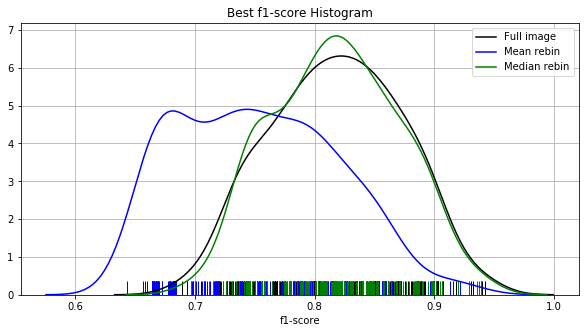

In [9]:
plt.figure(figsize=(10,5))
sns.distplot(f1_scores['full'], rug=True, hist=False, color='black', label = 'Full image')
sns.distplot(f1_scores['mean'], rug=True, hist=False, color='blue', label = 'Mean rebin')
sns.distplot(f1_scores['median'], rug=True, hist=False, color='green', label = 'Median rebin')
plt.grid()
plt.xlabel('f1-score')
plt.title('Best f1-score Histogram')

In [10]:
## pegando nome dos filtros (se repete n_filters a cada imagem)
filter_names = np.array(data['Filter_name'][0:roc_full_image.shape[3]])
params = np.array(data['Filter_parameter'][0:roc_full_image.shape[3]])

## Avaliando os resultados de cada filtro

### Imagem Full

Filter Name    Parameter      F1-score
-------------  -----------  ----------
bilateral      [17, 1, 9]     0.903224
bm3D           [5]            0.840248
cygno          none           0.707836
gaussian       [15]           0.917907
mean           [15]           0.906732
median         [15]           0.89186
nlmeans        [1, 13]        0.942476
wiener         [1]            0.755009


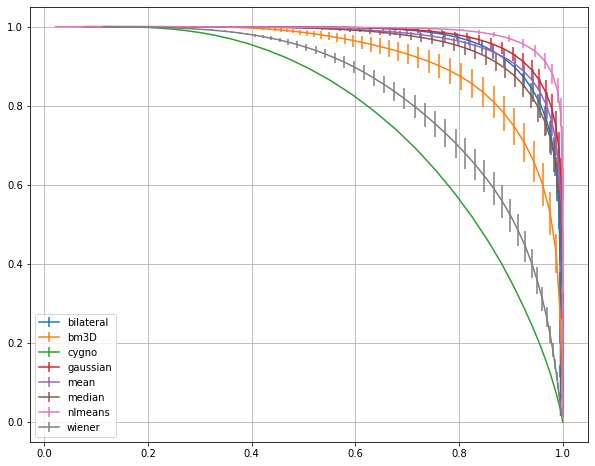

In [11]:
plt.figure(figsize=(10,8))
element = 'full'
roc_mean = mean_roc_full_image
roc_std = std_roc_full_image
result_table = []
f1_best = {}
f1_list = []
for fname in np.unique(filter_names):
    indexes = filter_names==fname
    best_f1_values = f1_scores[element][indexes].max()
    best_index = f1_scores[element][indexes].argmax()
    params_each_index = params[indexes][best_index]
    best_roc_curve = roc_mean[:, :, indexes][:, :, best_index]
    best_roc_curve_error = roc_std[:, :, indexes][:, :, best_index]/np.sqrt(n_images)
    plt.errorbar(best_roc_curve[0], best_roc_curve[1], best_roc_curve_error[1,:] ,label=fname)
    result_table.append([fname, params_each_index, best_f1_values])
    f1_list.append(best_roc_curve)

f1_best[element] = np.array(f1_list)    
plt.legend()
plt.grid()
print(tabulate(result_table, headers=['Filter Name', 'Parameter', 'F1-score']))

### Imagem rebinada (utilizando média)

Filter Name    Parameter      F1-score
-------------  -----------  ----------
bilateral      [17, 1, 9]     0.861028
bm3D           [5]            0.797135
cygno          none           0.720481
gaussian       [15]           0.886143
mean           [15]           0.859651
median         [15]           0.838776
nlmeans        [1, 15]        0.921716
wiener         [1]            0.668521


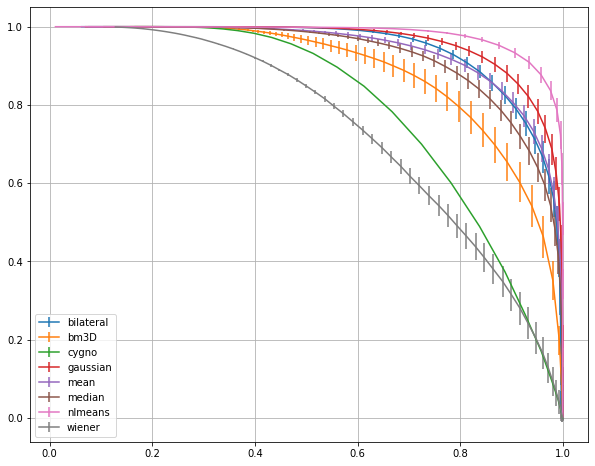

In [12]:
plt.figure(figsize=(10,8))
element = 'mean'
roc_mean = mean_roc_rebin_mean
roc_std = std_roc_full_image
result_table = []
f1_list = []
for fname in np.unique(filter_names):
    indexes = filter_names==fname
    best_f1_values = f1_scores[element][indexes].max()
    best_index = f1_scores[element][indexes].argmax()
    params_each_index = params[indexes][best_index]
    best_roc_curve = roc_mean[:, :, indexes][:, :, best_index]
    best_roc_curve_error = roc_std[:, :, indexes][:, :, best_index]/np.sqrt(n_images)
    plt.errorbar(best_roc_curve[0], best_roc_curve[1], best_roc_curve_error[1,:] ,label=fname)
    result_table.append([fname, params_each_index, best_f1_values])
    f1_list.append(best_roc_curve)

f1_best[element] = np.array(f1_list)        
plt.legend()
plt.grid()
print(tabulate(result_table, headers=['Filter Name', 'Parameter', 'F1-score']))

### Imagem rebinada (utilizando mediana)

Filter Name    Parameter      F1-score
-------------  -----------  ----------
bilateral      [17, 1, 9]     0.901612
bm3D           [2]            0.847894
cygno          none           0.816813
gaussian       [15]           0.91997
mean           [15]           0.906264
median         [15]           0.890455
nlmeans        [1, 13]        0.939127
wiener         [1]            0.746315


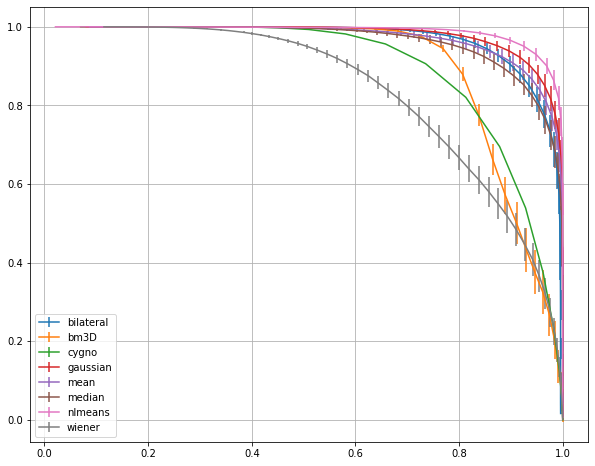

In [13]:
plt.figure(figsize=(10,8))
element = 'median'
roc_mean = mean_roc_rebin_median
roc_std = std_roc_full_image
result_table = []
f1_list = []
for fname in np.unique(filter_names):
    indexes = filter_names==fname
    best_f1_values = f1_scores[element][indexes].max()
    best_index = f1_scores[element][indexes].argmax()
    params_each_index = params[indexes][best_index]
    best_roc_curve = roc_mean[:, :, indexes][:, :, best_index]
    best_roc_curve_error = roc_std[:, :, indexes][:, :, best_index]/np.sqrt(n_images)
    plt.errorbar(best_roc_curve[0], best_roc_curve[1], best_roc_curve_error[1,:] ,label=fname)
    result_table.append([fname, params_each_index, best_f1_values])
    f1_list.append(best_roc_curve)

f1_best[element] = np.array(f1_list)        
plt.legend()
plt.grid()
print(tabulate(result_table, headers=['Filter Name', 'Parameter', 'F1-score']))

Text(0, 0.5, 'Rebin Image')

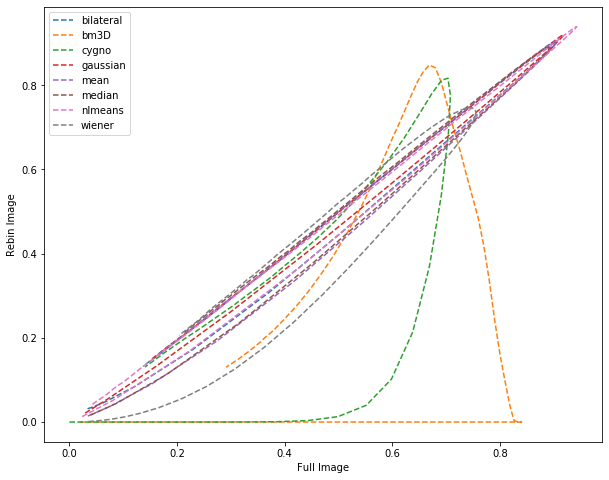

In [14]:
plt.figure(figsize=(10,8))
for i,fname in list(enumerate(np.unique(filter_names))):
    x_f = f1_best['full'][i, 0, :]
    y_f = f1_best['full'][i, 1, :]
    x_rb = f1_best['median'][i, 0, :]
    y_rb = f1_best['median'][i, 1, :]
    f_score_full = (2*x_f * y_f)/(x_f + y_f)
    f_score_rb = (2*x_rb * y_rb)/(x_rb + y_rb)
    plt.plot(f_score_full, f_score_rb, '--', label=fname)
plt.legend()    
plt.xlabel('Full Image')
plt.ylabel('Rebin Image')

##### A partir das roc's, é possível perceber que:

    -A mudança do tipo de rebin pode melhorar ou piorar o comportamento de alguns filtros
    -Processamentos com a tendência de espalhar o ruído, tendem a melhorar quando utilizamos a mediana ao fazer a rebinagem.
    -Somente o Block Matching 3D mudou seu parâmetro de acordo com a realização da rebinagem, isso indica que, para os filtros analisados até aqui, podemos escolher o melhor parâmetro sem a necessidade de realizar a rebinagem.
    
##### Qual o efeito disso para a clusterização?

In [15]:
n_pixels_sg_mean = np.array(data['count'], np.dtype('int')).mean()
print(n_pixels_sg_mean)

13392.56862745098


##### Uma imagem 2048x2048 possui, em média, 12630 pixels de sinal. Portanto, sendo os demais background, temos:

(2048x2048 - 12630) pixels de background.

O número de pixels enviados ao dbscan deve ser próximo de 25k. Assim, para detecção de todos os pixels de sinal, deveriamos enviar ao dbscan: (25000 - 12630) pixels de background = 12370 pixels.

Esse valor corresponde a uma rejeição de background de 99,70%

###### Uma imagem 512x512 possui, em média, 900 pixels de sinal para rebin utilizando mediana e 1400 pixels de sinal para rebin utilizando a média. Portanto:

(512x512 - 900) pixels de background (rebin mediana)


(512x512 - 1400) pixels de background (rebin media)

Considerando os 25k enviados ao dbscan, temos:

(25000 - 900) pixels de background enviados ao dbscan (rebin mediana)

(25000 - 1400) pixels de background enviados ao dbscan (rebin media)

esses valores correspondem, respectivamente a, 90,80% e 91,00% de rejeição de background nas imagens após rebin de mediana e média.

### Resultado prático cygno

In [16]:
from IPython.display import HTML

HTML(filename='../data/cygno.html')

### Resultado prático nlmeans

In [51]:
HTML(filename='../data/nl_means.html')

## Análise da Clusterização

In [18]:
## Resultados da clusterização
with open('../data/clustering_eval.json', 'r') as JSON:
    json_dict = json.load(JSON)
data_with_cluster = json.loads(json_dict)   

In [19]:
data_with_cluster.keys()

dict_keys(['Image_index', 'Filter_name', 'Filter_parameter', 'time', 'ROC', 'Energy', 'Counts', 'Clustering'])

In [22]:
len(data_with_cluster['Clustering'])

100

In [45]:
output_data = {'filter_name': [],
               'f1_score': [],
               'eps': [],
               'min_samples': []}
for cluster_info in data_with_cluster['Clustering']:
    for ind in range(len(cluster_info['filter_name'])):
        output_data['filter_name'].append(cluster_info['filter_name'][ind])
        output_data['f1_score'].append(cluster_info['best_point'][ind])
        output_data['eps'].append(cluster_info['best_parameters'][ind][0])
        output_data['min_samples'].append(cluster_info['best_parameters'][ind][1])

In [52]:
cluster_results_table = pd.DataFrame(output_data)
cluster_results_table.head()

,filter_name,f1_score,eps,min_samples
0,cygno,0.043317,1.018880,5
1,nlmeans,0.023452,11.317872,190
2,gaussian,0.012501,8.509617,119
3,cygno,0.267521,1.017281,5
4,nlmeans,0.048678,8.999783,137


## Melhor F1-score para cada método

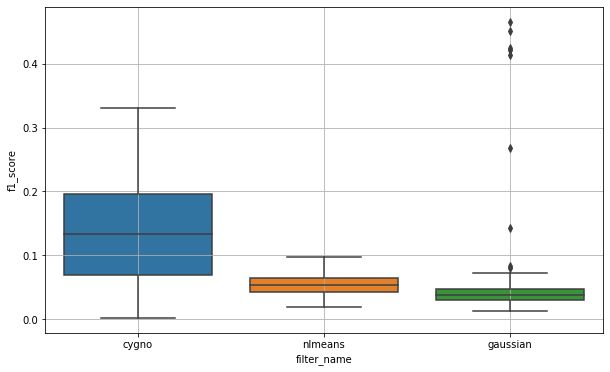

In [56]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="filter_name", y="f1_score", data=cluster_results_table)
plt.grid()

## Melhores parâmetros

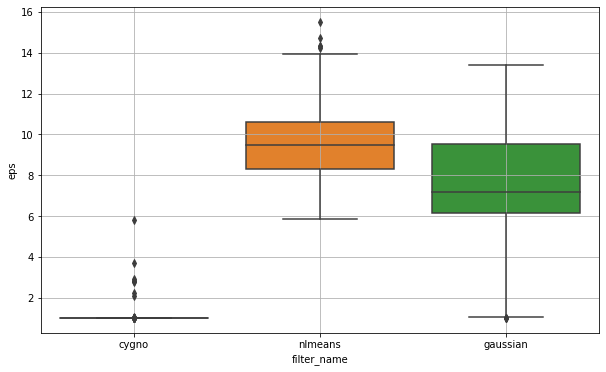

In [57]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="filter_name", y="eps", data=cluster_results_table)
plt.grid()

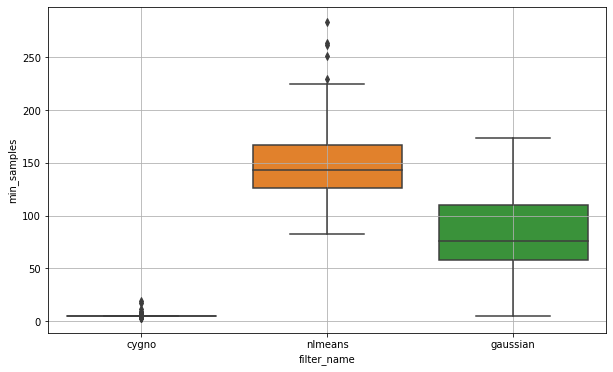

In [58]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="filter_name", y="min_samples", data=cluster_results_table)
plt.grid()

## Análise de Energia

In [59]:
data_with_cluster['Energy'].keys()
# image_truth -> soma de intensidades antes de inserir ruído
# image_real -> soma de intensidades após inserção e remoção de pedestal
# image_after_threshold -> array com energias de acordo com o threshold escolhido

dict_keys(['image_truth', 'image_no_ped', 'image_after_threshold', 'image_real'])

In [60]:
data_with_cluster['Energy']['image_truth']

18918.0